In [27]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [28]:
#  Import and read the csv
stroke_df = pd.read_csv("resources/healthcare-dataset-stroke-data.csv")
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [29]:
## remove the id column
stroke_df = stroke_df.drop(columns=['id'])

## Data Inspection

In [31]:
# Quick glance at what single variable has the highest correlation with a stroke
stroke_df.corr()['stroke']\
    .sort_values(ascending=False)

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64

<AxesSubplot:>

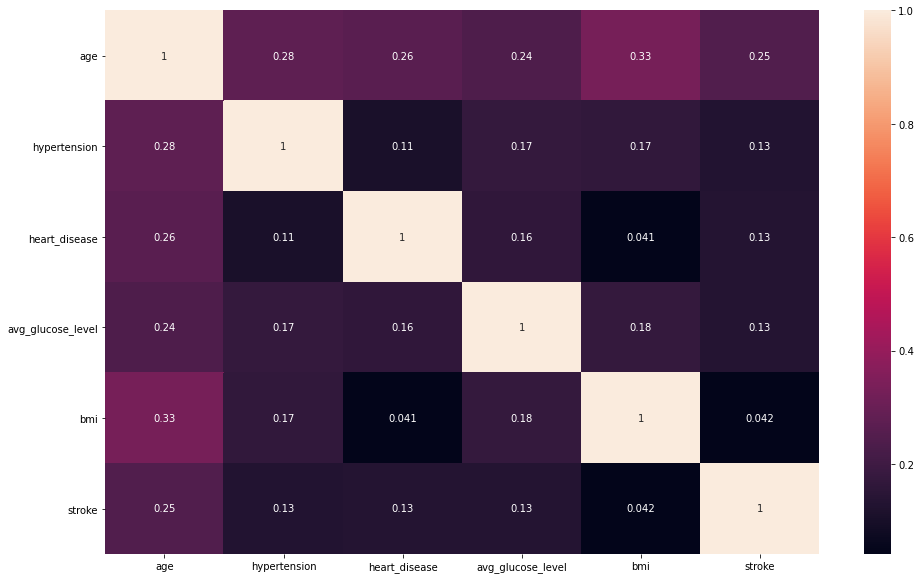

In [30]:
# Visualize the correlations.
import seaborn as sb
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sb.heatmap(stroke_df.corr(), annot=True)

### Quick analysis 

A quick glance shows that age seems to be the most correlated with having a stroke

## Prepare to build a supervised neural network model

In [4]:
# Determine the number of unique values in each column.
stroke_df.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

### Possible binning fields

- work_type

In [5]:
# Look at work_type value counts for binning
work_type_counts = stroke_df.work_type.value_counts()
work_type_counts

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

<AxesSubplot:ylabel='Density'>

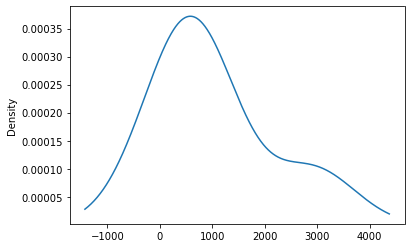

In [6]:
work_type_counts.plot.density()

Looks like there isn't binning worth in work_types field

## Classify the data

In [7]:
# Generate categorical variable list
stroke_cat = stroke_df.dtypes[stroke_df.dtypes == "object"].index.tolist()

In [8]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(stroke_df[stroke_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(stroke_cat)
encode_df.head()

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# Merge one-hot encoded features and drop the originals
stroke_df = stroke_df.merge(encode_df, left_index=True, right_index=True)
stroke_df = stroke_df.drop(stroke_cat, 1)
stroke_df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,61.0,0,0,202.21,NaN,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,80.0,0,1,105.92,32.5,1,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,49.0,0,0,171.23,34.4,1,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,79.0,1,0,174.12,24.0,1,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Build the model

In [10]:
# Split our preprocessed data into our features and target arrays
y = stroke_df.stroke
X = stroke_df.drop(columns=['stroke'])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [11]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
# Create a checkpoint of the model
checkpoint_filepath = 'resources/model/checkpoints/stroke_data_analysis.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy', 
    mode='max',
    save_best_only=True,
    save_freq=5,
    verbrose=1
)

In [13]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    Dense(
        units=number_input_features * 2,
        input_dim=number_input_features,
        activation='relu'
    )
)

# Second hidden layer
nn.add(
    Dense(
        units=number_input_features,
        activation='relu'
    )
)

# Output layer
nn.add(
    Dense(
        units=1,
        activation='sigmoid'
    )
)

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                924       
_________________________________________________________________
dense_1 (Dense)              (None, 21)                903       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 22        
Total params: 1,849
Trainable params: 1,849
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

# Fit the model
nn.fit(
    X_train_scaled, 
    np.asarray(y_train), 
    epochs=100,
    callbacks=checkpoint_callback
)

Epoch 1/100
120/120 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.9439
Epoch 2/100
120/120 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9496
Epoch 3/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 4/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 5/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 6/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 7/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 8/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 9/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 10/100
120/120 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9496
Epoch 11/100
120/12

In [15]:
# The model weights (that are considered the best) are loaded into the model.
nn.load_weights(checkpoint_filepath)

# Check accuracy
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

40/40 - 0s - loss: nan - accuracy: 0.9562
Loss: nan, Accuracy: 0.956181526184082


In [16]:
# Save the model
nn.save('resources/model/stroke_data_analysis.h5')